## Library version check

In [1]:
import sys
import sktime
import tqdm as tq
import lightgbm as lgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import math
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("lightgbm version: {}".format(lgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.5.2
numpy version: 1.21.6
matplotlib version: 3.5.2
tqdm version: 4.65.2
sktime version: 0.20.1
lightgbm version: 3.3.5
seaborn version: 0.11.2
scikit-learn version: 1.1.3
------------------------------------------------------------------------------


## 0. load the libararies

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import StratifiedKFold , KFold
from sktime.utils.plotting import plot_series
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', 30)

## 1. preprocessing the data

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
info = pd.read_csv('./data/building_info.csv')

info = info.iloc[:,:4]
train = train.merge(info,on='건물번호',how='left')

#전력소비량 이상치 처리(건물번호를 기준)
for num in tqdm(range(train['건물번호'].nunique())):
    train.loc[train['건물번호'] == num+1, '전력소비량(kWh)'] = train.loc[train['건물번호'] == num+1, '전력소비량(kWh)'].clip(train.loc[train['건물번호'] == num+1, '전력소비량(kWh)'].quantile(.01), train.loc[train['건물번호'] == num+1, '전력소비량(kWh)'].quantile(.99))

## 변수들을 영문명으로 변경
cols = ['num_date_time', 'build_num', 'date_time', 'temp' ,'prec', 'wind', 'hum', 'isolation', 'sunshine', 'power','use','area_1','area_2']
train.columns = cols

def summer_cos(date):
    start_date = datetime.strptime("2024-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime("2024-09-14 00:00:00", "%Y-%m-%d %H:%M:%S")

    period = (end_date - start_date).total_seconds()

    return math.cos(2 * math.pi * (date - start_date).total_seconds() / period)

def summer_sin(date):
    start_date = datetime.strptime("2024-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    end_date = datetime.strptime("2024-09-14 00:00:00", "%Y-%m-%d %H:%M:%S")

    period = (end_date - start_date).total_seconds()

    return math.sin(2 * math.pi * (date - start_date).total_seconds() / period)

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['date_time'] = pd.to_datetime(train['date_time'])
train['date'] = date.dt.date
train['hour'] = date.dt.hour
train['day'] = date.dt.day
train['weekday'] = date.dt.weekday
train['month'] = date.dt.month

# 이상치 처리
train.loc[13238:13826, 'power'] += 3500
train.loc[19161:20343, 'power'] -= 4000
train = train.drop(index=range(114240, 114408))
train = train.reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 236.41it/s]


In [4]:
def batch_interpolate_building_power(df, targets, target_col='power', method='time'):
    """
    여러 건물/시점(단일 or 구간)에 대해 시간 기반 보간을 한 번에 적용하는 함수.

    Parameters:
        df (pd.DataFrame): 전체 데이터프레임
        targets (list of tuples): 
            [(build_num, start_time), (build_num, start_time, end_time), ...] 형태의 리스트
            - end_time이 없으면 단일 시점 처리
        target_col (str): 보간할 컬럼명
        method (str): pandas.interpolate method

    Returns:
        pd.DataFrame: 보간이 적용된 원본 데이터프레임
    """
    for item in targets:
        # 튜플 길이에 따라 단일 시점/구간 처리
        if len(item) == 2:
            build_num, start_time = item
            end_time = None
        elif len(item) == 3:
            build_num, start_time, end_time = item
        else:
            raise ValueError("targets는 (build_num, start_time) 또는 (build_num, start_time, end_time) 형식이어야 합니다.")

        # 대상 건물 데이터 추출
        building = df[df['build_num'] == build_num].sort_values('date_time').copy()

        # 결측 처리
        if end_time is None:
            mask_missing = (building['date_time'] == pd.Timestamp(start_time))
        else:
            mask_missing = (
                (building['date_time'] >= pd.Timestamp(start_time)) &
                (building['date_time'] <= pd.Timestamp(end_time))
            )
        building.loc[mask_missing, target_col] = np.nan

        # 시간 기반 보간
        building.set_index('date_time', inplace=True)
        building[target_col] = building[target_col].interpolate(method=method)
        building.reset_index(inplace=True)

        # 원본 반영
        df.loc[df['build_num'] == build_num, target_col] = building[target_col].values

    return df

targets = [
    (3, '2024-07-17 14:00'),
    (7, '2024-08-06 03:00'),
    (18, '2024-07-17 14:00'),
    (30, '2024-07-13 20:00'),
    (30, '2024-07-25 00:00'),
    (42, '2024-07-17 14:00'),
    (47, '2024-07-17 14:00'),
    (55, '2024-07-17 14:00'),
    (76, '2024-08-22 21:00'),
    (81, '2024-06-27 14:00'),
    (81, '2024-07-17 14:00'),
    (82, '2024-07-17 14:00'),
    (83, '2024-07-17 14:00'), 
    (5, '2024-08-04 06:00', '2024-08-04 08:00'), 
    (18, '2024-06-11 17:00', '2024-06-11 18:00'), 
    (18, '2024-08-08 15:00', '2024-08-08 16:00'), 
    (28, '2024-07-17 14:00', '2024-07-17 15:00'), 
    (38, '2024-07-17 14:00', '2024-07-17 15:00'), 
    (41, '2024-07-17 09:00', '2024-07-17 15:00'), 
    (60, '2024-07-17 14:00', '2024-07-17 15:00'), 
    (62, '2024-07-17 13:00', '2024-07-17 15:00'), 
    (69, '2024-07-17 14:00', '2024-07-17 15:00'),  
    (76, '2024-06-20 12:00', '2024-06-20 16:00'),  
    (78, '2024-07-17 13:00', '2024-07-17 14:00'),
    (89, '2024-07-12 08:00', '2024-07-12 10:00'), 
    (97, '2024-07-17 13:00', '2024-07-17 15:00'), 
]

train = batch_interpolate_building_power(train, targets)

In [5]:
def batch_apply_pattern_scaling(df, tasks, target_col='power'):
    """
    여러 패턴 복사 작업을 한 번에 처리.
    Parameters:
        df (pd.DataFrame): 전체 데이터프레임
        tasks (list of tuples): 
            [
                (build_num, source_start, source_end, value_start, value_end, target_start, target_end),
                ...
            ]
        target_col (str): 수정할 컬럼명
    Returns:
        pd.DataFrame: 수정된 데이터프레임
    """
    for build_num, source_start, source_end, value_start_time, value_end_time, target_start, target_end in tasks:
        # 1. 원본 패턴 추출
        pattern_mask = (
            (df['build_num'] == build_num) &
            (df['date_time'] >= pd.Timestamp(source_start)) &
            (df['date_time'] <= pd.Timestamp(source_end))
        )
        P_source = df.loc[pattern_mask].sort_values('date_time')[target_col].values
        if len(P_source) == 0:
            continue  # 패턴 없으면 스킵

        # 2. 시작/종료 값
        V_start = df.loc[
            (df['build_num'] == build_num) & (df['date_time'] == pd.Timestamp(value_start_time)),
            target_col
        ].values[0]
        V_end = df.loc[
            (df['build_num'] == build_num) & (df['date_time'] == pd.Timestamp(value_end_time)),
            target_col
        ].values[0]

        # 3. 정규화 및 스케일링
        P_min, P_max = P_source.min(), P_source.max()
        P_scaled = (P_source - P_min) / (P_max - P_min + 1e-8)
        P_target = V_start + (V_end - V_start) * P_scaled

        # 4. 대상 구간 인덱스
        target_mask = (
            (df['build_num'] == build_num) &
            (df['date_time'] >= pd.Timestamp(target_start)) &
            (df['date_time'] <= pd.Timestamp(target_end))
        )
        target_indices = df.loc[target_mask].sort_values('date_time').index

        # 5. 길이 맞춰 삽입
        length = min(len(P_target), len(target_indices))
        df.loc[target_indices[:length], target_col] = P_target[:length]

    return df

tasks = [
    (7, '2024-06-30 10:00', '2024-07-01 11:00', '2024-07-07 09:00', '2024-07-08 12:00', '2024-07-07 10:00', '2024-07-08 11:00'),
    (7, '2024-07-05 14:00', '2024-07-05 23:00', '2024-07-12 13:00', '2024-07-13 00:00', '2024-07-12 14:00', '2024-07-12 23:00'),
]

train = batch_apply_pattern_scaling(train, tasks)

In [6]:
def batch_fill_hourly_means(df, tasks, target_col='power'):
    """
    여러 건물/기간/시간대 평균을 다른 날짜로 삽입하는 배치 함수.

    Parameters:
        df (pd.DataFrame): 전체 데이터프레임
        tasks (list of tuples): 
            [
                (build_num, source_dates, source_hours, target_date),
                ...
            ]
            - source_dates: ('start_date','end_date') or ['date1','date2',...]
            - source_hours: [hour1, hour2, ...]
            - target_date: 단일 날짜
        target_col (str): 수정할 컬럼명 (기본 'power')
    Returns:
        pd.DataFrame: 수정된 데이터프레임
    """
    for build_num, source_dates, source_hours, target_date in tasks:
        building = df[df['build_num'] == build_num].copy()

        # 날짜 마스크 생성
        if isinstance(source_dates, (tuple, list)) and len(source_dates) == 2 and not isinstance(source_dates[0], (pd.Timestamp, str)):
            # 범위일 경우
            start_date, end_date = pd.to_datetime(source_dates[0]).date(), pd.to_datetime(source_dates[1]).date()
            mask_range = (
                (building['date_time'].dt.date >= start_date) &
                (building['date_time'].dt.date <= end_date) &
                (building['date_time'].dt.hour.isin(source_hours))
            )
        else:
            # 날짜 리스트일 경우
            date_list = [pd.to_datetime(d).date() for d in source_dates]
            mask_range = (
                (building['date_time'].dt.date.isin(date_list)) &
                (building['date_time'].dt.hour.isin(source_hours))
            )

        # 시간별 평균 계산
        hourly_means = (
            building[mask_range]
            .groupby(building['date_time'].dt.hour)[target_col]
            .mean()
            .to_dict()
        )

        # 타겟 날짜에 삽입
        for hour, mean_val in hourly_means.items():
            mask_fill = (
                (df['build_num'] == build_num) &
                (df['date_time'].dt.date == pd.to_datetime(target_date).date()) &
                (df['date_time'].dt.hour == hour)
            )
            df.loc[mask_fill, target_col] = mean_val

    return df

tasks = [
    (67, ('2024-06-03', '2024-06-07'), [16, 17, 18], '2024-06-10'),          # 6/3~6/7 오후 4~6시 평균 → 6/10
    (67, ('2024-07-29', '2024-07-31'), [15, 16], '2024-08-01'),              # 7/29~7/31 오후 3~4시 평균 → 8/1
    (67, ['2024-08-13', '2024-08-14', '2024-08-16'], [16, 17], '2024-08-12'), # 8/13,14,16 오후 4~5시 평균 → 8/12
    (80, ('2024-07-01', '2024-07-05'), [11,12,13,14,19,20], '2024-07-08')    # 7/1~7/5 11~14시,19~20시 평균 → 7/8
]

train = batch_fill_hourly_means(train, tasks)

In [7]:
def scale_power_segments(train: pd.DataFrame, segments: list):
    """
    주어진 구간의 power 값을 앞뒤 하루 같은 시간대 min-max 스케일로 보정.
    보정된 값은 train['power']에 덮어씌움.

    Parameters:
        train (pd.DataFrame): 'build_num', 'date_time', 'power' 컬럼 포함 데이터프레임
        segments (list): [(build_num, start_datetime, end_datetime), ...] 형식의 튜플 리스트
    Returns:
        pd.DataFrame: 보정된 train 데이터프레임
    """
    train['date_time'] = pd.to_datetime(train['date_time'])
    
    for build_num, start_str, end_str in segments:
        target_start = pd.Timestamp(start_str)
        target_end = pd.Timestamp(end_str)

        # 대상 건물 데이터
        building_data = train[train['build_num'] == build_num].sort_values(by='date_time')
        target_mask = (building_data['date_time'] >= target_start) & (building_data['date_time'] <= target_end)
        
        # 참조 구간: 앞뒤 하루 동일 시간대
        ref_mask = (
            ((building_data['date_time'] >= target_start - pd.Timedelta(days=1)) & (building_data['date_time'] <= target_end - pd.Timedelta(days=1))) |
            ((building_data['date_time'] >= target_start + pd.Timedelta(days=1)) & (building_data['date_time'] <= target_end + pd.Timedelta(days=1)))
        )
        ref_data = building_data.loc[ref_mask, 'power']
        if ref_data.empty:
            continue  # 참조 데이터가 없으면 스킵

        ref_min, ref_max = ref_data.min(), ref_data.max()
        target_data = building_data.loc[target_mask, 'power']
        if target_data.empty or target_data.max() == target_data.min():
            continue  # 대상 데이터가 없거나 변동이 없으면 스킵

        # 스케일 조정
        scaled = (target_data - target_data.min()) / (target_data.max() - target_data.min())  # 0~1 정규화
        scaled = scaled * (ref_max - ref_min) + ref_min

        # train에 덮어쓰기
        train.loc[target_mask & (train['build_num'] == build_num), 'power'] = scaled

    return train

segments = [
    (30, '2024-06-20 06:00', '2024-06-20 23:00'),
    (30, '2024-07-06 06:00', '2024-07-06 23:00'),
]

train = scale_power_segments(train, segments)

In [8]:
def fill_with_weekly_pattern(train: pd.DataFrame, build_num: int, start_str: str, end_str: str):
    """
    특정 구간을 앞주+다음주 동일 시각 데이터 평균으로 채우고 train['power']에 덮어씀.
    """
    train['date_time'] = pd.to_datetime(train['date_time'])
    building_data = train[train['build_num'] == build_num].sort_values(by='date_time')

    # 대상 구간
    target_start = pd.Timestamp(start_str)
    target_end = pd.Timestamp(end_str)
    target_mask = (building_data['date_time'] >= target_start) & (building_data['date_time'] <= target_end)
    target_range = building_data.loc[target_mask, ['date_time']].copy()
    if target_range.empty:
        print(f"⚠️ 대상 구간({start_str}~{end_str}) 데이터 없음")
        return train

    # 앞주 & 다음주 동일 시각 데이터 가져오기
    week_offset = pd.Timedelta(days=7)
    ref1 = building_data.set_index('date_time').loc[target_start - week_offset : target_end - week_offset, ['power']].reset_index()
    ref2 = building_data.set_index('date_time').loc[target_start + week_offset : target_end + week_offset, ['power']].reset_index()

    # 두 주 패턴 align (길이가 다를 경우 보정)
    if len(ref1) != len(target_range):
        ref1 = ref1.reindex(range(len(target_range)), method='nearest')
    if len(ref2) != len(target_range):
        ref2 = ref2.reindex(range(len(target_range)), method='nearest')

    # 두 주 평균 패턴 생성
    ref_mean = (ref1['power'].values + ref2['power'].values) / 2
    target_range['power_filled'] = ref_mean

    # 덮어쓰기
    for idx, row in target_range.iterrows():
        train.loc[
            (train['build_num'] == build_num) & (train['date_time'] == row['date_time']),
            'power'
        ] = row['power_filled']

    return train

# 7월 20일 02시 ~ 7월 22일 10시, 건물 49
train = fill_with_weekly_pattern(
    train, 
    build_num=43, 
    start_str="2024-07-20 02:00", 
    end_str="2024-07-22 10:00"
)

train = fill_with_weekly_pattern(
    train, 
    build_num=53, 
    start_str="2024-06-14 16:00", 
    end_str="2024-06-17 09:00"
)

train = fill_with_weekly_pattern(
    train, 
    build_num=67, 
    start_str="2024-07-27 00:00", 
    end_str="2024-07-28 00:00"
)

train = fill_with_weekly_pattern(
    train, 
    build_num=94, 
    start_str="2024-07-27 00:00", 
    end_str="2024-07-28 00:00"
)

In [9]:
def add_value_to_segment(train: pd.DataFrame, build_num: int, start_str: str, end_str: str, add_value: float):
    """
    특정 건물의 지정 구간에 일정 값을 더해 train['power']에 덮어씀.
    """
    train['date_time'] = pd.to_datetime(train['date_time'])
    target_start = pd.Timestamp(start_str)
    target_end = pd.Timestamp(end_str)

    mask = (
        (train['build_num'] == build_num) &
        (train['date_time'] >= target_start) &
        (train['date_time'] <= target_end)
    )

    train.loc[mask, 'power'] = train.loc[mask, 'power'] + add_value
    return train

train = add_value_to_segment(
    train,
    build_num=53,
    start_str="2024-08-18 16:00",
    end_str="2024-08-19 07:00",
    add_value=400
)

train = add_value_to_segment(
    train,
    build_num=67,
    start_str="2024-06-01 00:00",
    end_str="2024-06-03 09:00",
    add_value=780
)

# train = add_value_to_segment(
#     train,
#     build_num=10,
#     start_str="2024-06-01 00:00",
#     end_str="2024-07-04 07:00",
#     add_value=900
# )

In [10]:
def fill_with_prev_next_day_avg(train: pd.DataFrame, build_num: int, start_str: str, end_str: str):
    """
    특정 건물의 지정 구간을 하루 전/하루 뒤 동일 시간대의 평균 값으로 채움.
    train['power']에 덮어씀.
    """
    train['date_time'] = pd.to_datetime(train['date_time'])
    building_data = train[train['build_num'] == build_num].sort_values(by='date_time')

    # 대상 구간
    target_start = pd.Timestamp(start_str)
    target_end = pd.Timestamp(end_str)
    target_mask = (building_data['date_time'] >= target_start) & (building_data['date_time'] <= target_end)
    target_times = building_data.loc[target_mask, 'date_time']
    if target_times.empty:
        print(f"⚠️ 대상 구간({start_str}~{end_str}) 데이터 없음")
        return train

    # 하루 전/하루 뒤 동일 시간대 구간
    prev_day_mask = (building_data['date_time'] >= target_start - pd.Timedelta(days=1)) & (building_data['date_time'] <= target_end - pd.Timedelta(days=1))
    next_day_mask = (building_data['date_time'] >= target_start + pd.Timedelta(days=1)) & (building_data['date_time'] <= target_end + pd.Timedelta(days=1))
    prev_data = building_data.loc[prev_day_mask, ['date_time', 'power']]
    next_data = building_data.loc[next_day_mask, ['date_time', 'power']]

    if prev_data.empty and next_data.empty:
        print(f"⚠️ 참조 데이터 없음({start_str}~{end_str})")
        return train

    # 평균 패턴 계산 (있으면 합쳐서 평균)
    ref_values = []
    if not prev_data.empty:
        ref_values.append(prev_data['power'].values)
    if not next_data.empty:
        ref_values.append(next_data['power'].values)
    ref_mean = sum(ref_values) / len(ref_values)  # 두 날짜 평균

    # 길이가 다르면 맞춰서 채움
    ref_mean_series = pd.Series(ref_mean)
    ref_mean_series = ref_mean_series.reindex(range(len(target_times)), method='nearest')

    # 덮어쓰기
    train.loc[
        (train['build_num'] == build_num) & (train['date_time'] >= target_start) & (train['date_time'] <= target_end),
        'power'
    ] = ref_mean_series.values

    return train

train = fill_with_prev_next_day_avg(
    train,
    build_num=70,
    start_str="2024-06-04 09:00",
    end_str="2024-06-05 09:00"
)

In [11]:
def fill_power_with_holiday_pattern(train, build_num, date_ranges):
    """
    특정 건물의 지정 날짜 구간 전력 사용량을
    전후 holiday 패턴(같은 시간대 평균)으로 대체하는 함수.

    Parameters:
        train (pd.DataFrame): 전체 데이터프레임
        build_num (int): 건물 번호
        date_ranges (list of tuples): [(start_date, end_date), ...] 형식의 구간 리스트 (문자열 or Timestamp)
    Returns:
        pd.DataFrame: power가 덮어씌워진 원본 train DataFrame
    """
    # 데이터 정렬 및 시간 변환
    train['date_time'] = pd.to_datetime(train['date_time'])
    building_data = train[train['build_num'] == build_num].sort_values(by='date_time').copy()
    building_data['hour'] = building_data['date_time'].dt.hour

    # holiday 날짜
    holiday_dates = building_data[building_data['holiday'] == 1]['date_time']

    for start_date, end_date in date_ranges:
        target_start = pd.Timestamp(start_date)
        target_end = pd.Timestamp(end_date)

        # 전후 holiday 추출
        prev_holiday = holiday_dates[holiday_dates < target_start].max()
        next_holiday = holiday_dates[holiday_dates > target_end].min()
        if pd.isna(prev_holiday) or pd.isna(next_holiday):
            continue  # holiday 없으면 skip

        # 전후 holiday 패턴
        prev_pattern = building_data[building_data['date_time'].dt.date == prev_holiday.date()]
        next_pattern = building_data[building_data['date_time'].dt.date == next_holiday.date()]
        holiday_pattern = (prev_pattern.groupby('hour')['power'].mean() +
                           next_pattern.groupby('hour')['power'].mean()) / 2

        # 대체
        target_mask = (building_data['date_time'] >= target_start) & (building_data['date_time'] <= target_end)
        building_data.loc[target_mask, 'power'] = building_data.loc[target_mask].apply(
            lambda row: holiday_pattern.loc[row['hour']] if row['hour'] in holiday_pattern.index else row['power'],
            axis=1
        )

    # train에 반영
    train.loc[building_data.index, 'power'] = building_data['power']
    return train

In [12]:
import pandas as pd

def copy_pattern_by_days(
    df,
    build_num,
    target_start,
    target_end,
    offset_days,          # 예: -7(이전 주), +7(다음 주), +3(3일 뒤) 등
    col='power',
    dt_col='date_time',
    inplace=False
):
    """
    [target_start ~ target_end] 구간의 값을
    (offset_days 만큼 이동한 구간)의 패턴으로 덮어쓰기.
    """
    _df = df if inplace else df.copy()

    ts, te = pd.to_datetime(target_start), pd.to_datetime(target_end)
    ss, se = ts + pd.Timedelta(days=offset_days), te + pd.Timedelta(days=offset_days)

    m_src = (_df['build_num'] == build_num) & (_df[dt_col] >= ss) & (_df[dt_col] <= se)
    m_tgt = (_df['build_num'] == build_num) & (_df[dt_col] >= ts) & (_df[dt_col] <= te)

    src_vals = _df.loc[m_src].sort_values(dt_col)[col].values
    tgt_idx  = _df.loc[m_tgt].sort_values(dt_col).index

    if len(src_vals) == 0 or len(tgt_idx) == 0:
        return _df  # 소스/타겟이 없으면 그대로 반환

    n = min(len(src_vals), len(tgt_idx))
    _df.loc[tgt_idx[:n], col] = src_vals[:n]
    return _df


def batch_copy_patterns_by_days(
    df,
    jobs,                 # [(build_num, t_start, t_end, offset_days), ...] 또는 dict 리스트
    col='power',
    dt_col='date_time',
    inplace=False,
    verbose=False
):
    """
    여러 건을 한 번에 처리하는 배치 함수.
    jobs 원소 형태:
      - 튜플: (build_num, target_start, target_end, offset_days)
      - 딕셔너리: {
            "build_num": ...,
            "target_start": ...,
            "target_end": ...,
            # 아래 중 하나
            "offset_days": ...,
            "week_offset": ...  # 있으면 7*week_offset으로 변환
        }
      ※ offset_days가 있으면 week_offset보다 우선
    """
    def _parse(job):
        if isinstance(job, (list, tuple)) and len(job) == 4:
            b, ts, te, od = job
            return b, ts, te, od
        if isinstance(job, dict):
            b  = job['build_num']
            ts = job['target_start']
            te = job['target_end']
            if 'offset_days' in job:
                od = job['offset_days']
            elif 'week_offset' in job:
                od = 7 * job['week_offset']
            else:
                raise ValueError("dict job에는 'offset_days' 또는 'week_offset' 중 하나가 필요합니다.")
            return b, ts, te, od
        raise ValueError("jobs 항목은 (build_num, start, end, offset_days) 튜플 또는 해당 키를 가진 dict여야 합니다.")

    _df = df if inplace else df.copy()

    for job in jobs:
        b, ts, te, od = _parse(job)
        if verbose:
            print(f"[batch] build_num={b}, target=({ts}~{te}), offset_days={od}")
        _df = copy_pattern_by_days(
            _df, b, ts, te, od, col=col, dt_col=dt_col, inplace=True
        )
    return _df


jobs = [
    (5, "2024-08-04 00:00", "2024-08-04 23:00", -7),
    (6, "2024-08-15 00:00", "2024-08-15 23:00", -4),
    (6, "2024-08-16 00:00", "2024-08-16 23:00", -7),
    (6, "2024-08-17 00:00", "2024-08-17 23:00", -7),
    (6, "2024-08-18 00:00", "2024-08-18 23:00", -7),
    (7, "2024-07-07 10:00", "2024-07-08 11:00", -7),
    (8,  "2024-07-21 08:00", "2024-07-21 11:00", -7),
    (8,  "2024-08-24 00:00", "2024-08-24 23:00", -7),
    (12, "2024-07-21 00:00", "2024-07-21 23:00", +7),
    (12, "2024-08-24 00:00", "2024-08-24 23:00", -7),
    (17, "2024-06-25 15:00", "2024-06-26 09:00", -7),
    (20, "2024-06-01 00:00", "2024-06-01 23:00", +7),
    (25, "2024-07-04 12:00", "2024-07-04 14:00", +7),
    (26, "2024-06-17 14:00", "2024-06-18 11:00", -7),
    (29, "2024-06-15 22:00", "2024-06-15 23:00", -7),
    (29, "2024-06-27 00:00", "2024-06-27 01:00", -7),
    (30, "2024-08-04 00:00", "2024-08-04 23:00", -1),
    (30, "2024-08-05 00:00", "2024-08-05 23:00", -1),
    (30, "2024-08-07 00:00", "2024-08-07 23:00", -1),
    (40, "2024-07-14 00:00", "2024-07-14 01:00", -1),
    (41, "2024-06-22 01:00", "2024-06-22 04:00", -7),
    (41, "2024-07-17 00:00", "2024-07-17 23:00", -7),
    (42, "2024-07-17 00:00", "2024-07-17 23:00", -1),
    (43, "2024-06-10 17:00", "2024-06-10 18:00", -7),
    (43, "2024-08-12 16:00", "2024-08-12 17:00", -7),
    (43, "2024-07-20 00:00", "2024-07-21 23:00", -7),
    (67, "2024-07-26 00:00", "2024-07-27 23:00", -7),
    (68, "2024-06-28 23:00", "2024-06-29 01:00", -7),
    (72, "2024-07-21 10:00", "2024-07-21 11:00", -7),
    (76, "2024-06-03 13:00", "2024-06-03 13:00", -1),
    (76, "2024-06-20 12:00", "2024-06-20 15:00", -7),
    (78, "2024-07-17 14:00", "2024-07-17 14:00", -7),
    (80, "2024-07-06 10:00", "2024-07-06 15:00", -7),
    (80, "2024-07-08 12:00", "2024-07-08 13:00", -7),
    (80, "2024-07-20 10:00", "2024-07-20 12:00", -7),
    (88, "2024-08-23 07:00", "2024-08-23 08:00", -7),
    (90, "2024-06-05 18:00", "2024-06-05 18:00", -1),
    (92, "2024-07-17 18:00", "2024-07-17 21:00", -7),
    (94, "2024-07-26 20:00", "2024-07-28 10:00", -7),
    (97, "2024-07-17 14:00", "2024-07-17 14:00", -7),
    (98, "2024-06-13 15:00", "2024-06-13 15:00", -7)
]

train = batch_copy_patterns_by_days(train, jobs, col='power', dt_col='date_time', inplace=False, verbose=False)

In [13]:
# isolation = pd.pivot_table(train, values = 'isolation', index = ['build_num', 'hour', 'month'], aggfunc = np.mean).reset_index()
# sunshine = pd.pivot_table(train, values = 'sunshine', index = ['build_num', 'hour', 'month'], aggfunc = np.mean).reset_index()

## 건물별, 요일별, 시간별 전력소비량 평균
power_mean_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'weekday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['target_mean_1'] = train.progress_apply(lambda x : power_mean_1.loc[(power_mean_1.build_num == x['build_num']) & (power_mean_1.hour == x['hour']) & (power_mean_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

## 건물별, 요일별, 시간별 전력소비량 표준편차
power_std_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'weekday'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['target_std_1'] = train.progress_apply(lambda x : power_std_1.loc[(power_std_1.build_num == x['build_num']) & (power_std_1.hour == x['hour']) & (power_std_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

## 건물별, 요일별, 시간별 전력소비량 최소
power_min_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'weekday'], aggfunc = np.min).reset_index()
tqdm.pandas()
train['target_min_1'] = train.progress_apply(lambda x : power_min_1.loc[(power_min_1.build_num == x['build_num']) & (power_min_1.hour == x['hour']) & (power_min_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

## 건물별, 요일별, 시간별 전력소비량 최대
power_max_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'weekday'], aggfunc = np.max).reset_index()
tqdm.pandas()
train['target_max_1'] = train.progress_apply(lambda x : power_max_1.loc[(power_max_1.build_num == x['build_num']) & (power_max_1.hour == x['hour']) & (power_max_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

# 건물별, 시간별 전력소비량 평균
hour_mean_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean_1'] = train.progress_apply(lambda x : hour_mean_1.loc[(hour_mean_1.build_num == x['build_num']) & (hour_mean_1.hour == x['hour']) ,'power'].values[0], axis = 1)

# 건물별, 시간별 전력소비량 표준편차
hour_std_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std_1'] = train.progress_apply(lambda x : hour_std_1.loc[(hour_std_1.build_num == x['build_num']) & (hour_std_1.hour == x['hour']) ,'power'].values[0], axis = 1)

## 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)
train.loc[('20240606'<=train.date_time)&(train.date_time<'20240607'),'holiday'] = 1
train.loc[('20240815'<=train.date_time)&(train.date_time<'20240816'),'holiday'] = 1

# 규칙 정의 함수
def apply_holiday_rules(row):
    bn = row['build_num']
    wd = row['weekday']
    day = row['day']
    week = (row['day'] - 1) // 7 + 1

    # 📌 개별 규칙 적용
    if bn == 2:   
        return 1 if wd == 5 else 0
    elif bn == 7:   
        return 1 if wd == 6 else 0
    elif bn == 18:  
        return 1 if wd == 6 else 0
    elif bn == 19: 
        return 1 if wd == 0 and week == 2 else 0
    elif bn == 25:  
        return 0
    elif bn == 26:  
        return 0
    elif bn == 27:  
        return 1 if wd == 6 and week in [2, 4] else 0
    elif bn == 29:  
        return 1 if day == 10 else 0
    elif bn == 31:  
        return 0
    elif bn == 32:  
        return 1 if wd == 0 and week in [2, 4] else 0
    elif bn == 34:  
        return 0
    elif bn == 35: 
        return 0
    elif bn == 40:
        return 1 if wd == 6 and week in [2, 4] else 0
    elif bn == 41:
        return 0
    elif bn == 54:
        return 0
    elif bn == 57:
        return 0
    elif bn == 58:
        return 0
    elif bn == 59:
        return 1 if wd == 6 and week in [2, 4] else 0
    elif bn == 61:
        return 0
    elif bn == 63:
        return 1 if wd == 6 and week in [2, 4] else 0
    elif bn == 97:
        return 0
    elif bn == 99:
        return 1 if wd == 2 else 0
    elif bn in [1,4,9,10,11,28,30,33,43,45,65,70,71,73,74,76,77,78,79,82,84,85,88,89,91,92,93,95,96,98,100]:
        return 0
    else:
        return row['holiday']

# 규칙 적용
train['holiday'] = train.apply(apply_holiday_rules, axis=1)

single_day_holidays = [
    (19, '2024-06-10'),
    (19, '2024-07-08'),
    (19, '2024-08-19'),
    (23, '2024-06-07'),
    (23, '2024-08-16'),
    (29, '2024-06-23'),
    (29, '2024-07-28'),
    (45, '2024-06-10'),
    (45, '2024-07-08'),
    (45, '2024-08-19'),
    (49, '2024-08-22'),
    (54, '2024-06-17'),
    (54, '2024-07-01'),
    (54, '2024-08-19'),
    (67, '2024-07-26'),
    (74, '2024-06-17'),
    (74, '2024-07-01'),
    (79, '2024-06-17'),
    (79, '2024-07-01'),
    (79, '2024-08-19'),
    (94, '2024-06-07'),
    (94, '2024-08-16'),
    (95, '2024-07-08'),
    (95, '2024-08-05'),
]

for build_num, date_str in single_day_holidays:
    target_date = pd.to_datetime(date_str).date()  # 날짜만 비교
    train.loc[
        (train['build_num'] == build_num) & 
        (train['date_time'].dt.date == target_date),
        'holiday'
    ] = 1

single_day_no_holiday = [
    (67, '2024-06-06')
]

for build_num, date_str in single_day_no_holiday:
    target_date = pd.to_datetime(date_str).date()  # 날짜만 비교
    train.loc[
        (train['build_num'] == build_num) & 
        (train['date_time'].dt.date == target_date),
        'holiday'
    ] = 0

date_ranges = [
    ('2024-07-26 00:00:00', '2024-07-26 23:59:59'),
]
train = fill_power_with_holiday_pattern(train, build_num=67, date_ranges=date_ranges)

# 건물별, 휴일별, 시간별 전력소비량 평균
power_holiday_mean_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'holiday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['holiday_mean_1'] = train.progress_apply(lambda x : power_holiday_mean_1.loc[(power_holiday_mean_1.build_num == x['build_num']) & (power_holiday_mean_1.hour == x['hour']) & (power_holiday_mean_1.holiday == x['holiday']) ,'power'].values[0], axis = 1)

# 건물별, 휴일별, 시간별 전력소비량 표준편차
power_holiday_std_1 = pd.pivot_table(train, values = 'power', index = ['build_num', 'hour', 'holiday'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['holiday_std_1'] = train.progress_apply(lambda x : power_holiday_std_1.loc[(power_holiday_std_1.build_num == x['build_num']) & (power_holiday_std_1.hour == x['hour']) & (power_holiday_std_1.holiday == x['holiday']) ,'power'].values[0], axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_hour'] = np.sin(2*np.pi*train.hour/24)
train['cos_hour'] = np.cos(2*np.pi*train.hour/24)
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12)
train['sin_weekday'] = -np.sin(2 * np.pi * (train['weekday']+1)/7.0)
train['cos_weekday'] = -np.cos(2 * np.pi * (train['weekday']+1)/7.0)

#summer_sin, cos
train['summer_sin'] = train['date_time'].apply(summer_sin)
train['summer_cos'] = train['date_time'].apply(summer_cos)

## 화씨 온도
train['temp_F'] = (train['temp'] * 9/5) + 32 

## 체감 온도
train['WC']=13.12+0.6215*train['temp']-13.947*train['wind']**0.16+0.486*train['temp']*train['wind']**0.16

## 불쾌 지수
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

train['dew_point'] = train['temp'] - (100 - train['hum']) / 5
train['log_temp'] = np.log1p(train['temp'])

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['build_num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

## mean temperature
train = train.merge(train[train['hour']%3==0].groupby(['build_num','date'])['temp'].mean().reset_index().rename(columns = {'temp':'mean_temp'}), on = ['build_num','date'], how = 'left')

## min temperature
train = train.merge(train[train['hour']%3==0].groupby(['build_num','date'])['temp'].min().reset_index().rename(columns = {'temp':'min_temp'}), on = ['build_num','date'], how = 'left')

## max temperature
train = train.merge(train[train['hour']%3==0].groupby(['build_num','date'])['temp'].max().reset_index().rename(columns = {'temp':'max_temp'}), on = ['build_num','date'], how = 'left')

## mean windspeed
train = train.merge(train.groupby(['build_num','date'])['wind'].mean().reset_index().rename(columns = {'wind':'mean_wind'}), on = ['build_num','date'], how = 'left')

# ## min windspeed
# train = train.merge(train.groupby(['build_num','date'])['wind'].min().reset_index().rename(columns = {'wind':'min_wind'}), on = ['build_num','date'], how = 'left')

# ## max windspeed
# train = train.merge(train.groupby(['build_num','date'])['wind'].max().reset_index().rename(columns = {'wind':'max_wind'}), on = ['build_num','date'], how = 'left')

## mean humidity
train = train.merge(train.groupby(['build_num','date'])['hum'].mean().reset_index().rename(columns = {'hum':'mean_hum'}), on = ['build_num','date'], how = 'left')

# ## min humidity
# train = train.merge(train.groupby(['build_num','date'])['hum'].min().reset_index().rename(columns = {'hum':'min_hum'}), on = ['build_num','date'], how = 'left')

# ## max humidity
# train = train.merge(train.groupby(['build_num','date'])['hum'].max().reset_index().rename(columns = {'hum':'max_hum'}), on = ['build_num','date'], how = 'left')

## mean THI
train = train.merge(train.groupby(['build_num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['build_num','date'], how = 'left')

## mean CDH
train = train.merge(train.groupby(['build_num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['build_num','date'], how = 'left')

## mean WC
train = train.merge(train.groupby(['build_num','date'])['WC'].mean().reset_index().rename(columns = {'WC':'mean_WC'}), on = ['build_num','date'], how = 'left')

## z-score
train['z_score'] = train['target_mean_1'] / train['target_std_1']

## temp_diff
train['temp_diff'] = train['max_temp'] - train['min_temp']

train.drop(columns=['date','day'], inplace=True)
train.head()

100%|████████████████████████████████████████████████████████████████████████| 203832/203832 [01:50<00:00, 1846.34it/s]


,num_date_time,build_num,date_time,temp,prec,wind,hum,isolation,sunshine,power,use,area_1,area_2,hour,weekday,...,WC,THI,dew_point,log_temp,CDH,mean_temp,min_temp,max_temp,mean_wind,mean_hum,mean_THI,mean_CDH,mean_WC,z_score,temp_diff
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,호텔,82912.71,77586.0,0,5,...,18.605526,52.9016,14.7,2.960105,-7.7,20.6125,17.6,24.8,2.75,63.375,53.788788,-53.0625,21.342341,11.353622,7.2
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,호텔,82912.71,77586.0,1,5,...,18.569864,52.9016,14.7,2.960105,-15.4,20.6125,17.6,24.8,2.75,63.375,53.788788,-53.0625,21.342341,10.540611,7.2
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,호텔,82912.71,77586.0,2,5,...,18.367969,51.6000,14.1,2.949688,-23.3,20.6125,17.6,24.8,2.75,63.375,53.788788,-53.0625,21.342341,9.252619,7.2
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,호텔,82912.71,77586.0,3,5,...,18.249191,51.8809,14.2,2.944439,-31.3,20.6125,17.6,24.8,2.75,63.375,53.788788,-53.0625,21.342341,7.118597,7.2
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,호텔,82912.71,77586.0,4,5,...,18.659442,51.5209,14.0,2.933857,-39.5,20.6125,17.6,24.8,2.75,63.375,53.788788,-53.0625,21.342341,7.868436,7.2


In [14]:
# train set과 동일한 전처리 과정
test['일시'] = pd.to_datetime(test['일시'])
test = test.merge(info,on='건물번호',how='left')
cols = ['num_date_time', 'build_num', 'date_time', 'temp' , 'prec', 'wind', 'hum','use','area_1','area_2']

test.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(test.date_time)
test['date'] = date.dt.date
test['hour'] = date.dt.hour
test['day'] = date.dt.day
test['weekday'] = date.dt.weekday
test['month'] = date.dt.month

test['holiday'] = test.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)
test['holiday'] = test.apply(apply_holiday_rules, axis=1)

# ## 일조
# tqdm.pandas()
# test['isolation'] = np.round(test.progress_apply(lambda x : isolation.loc[(isolation.build_num == x['build_num']) & (isolation.hour == x['hour']) & (isolation.month == x['month']) ,'isolation'].values[0], axis = 1), 1)

# ## 일사
# tqdm.pandas()
# test['sunshine'] = np.round(test.progress_apply(lambda x : sunshine.loc[(sunshine.build_num == x['build_num']) & (sunshine.hour == x['hour']) & (sunshine.month == x['month']) ,'sunshine'].values[0], axis = 1), 2)

# 건물별, 요일별, 시간별 전력소비량 평균
tqdm.pandas()
test['target_mean_1'] = test.progress_apply(lambda x : power_mean_1.loc[(power_mean_1.build_num == x['build_num']) & (power_mean_1.hour == x['hour']) & (power_mean_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

# 건물별, 요일별, 시간별 전력소비량 표준편차
tqdm.pandas()
test['target_std_1'] = test.progress_apply(lambda x : power_std_1.loc[(power_std_1.build_num == x['build_num']) & (power_std_1.hour == x['hour']) & (power_std_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['target_min_1'] = test.progress_apply(lambda x : power_min_1.loc[(power_min_1.build_num == x['build_num']) & (power_min_1.hour == x['hour']) & (power_min_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['target_max_1'] = test.progress_apply(lambda x : power_max_1.loc[(power_max_1.build_num == x['build_num']) & (power_max_1.hour == x['hour']) & (power_max_1.weekday == x['weekday']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['holiday_mean_1'] = test.progress_apply(lambda x : power_holiday_mean_1.loc[(power_holiday_mean_1.build_num == x['build_num']) & (power_holiday_mean_1.hour == x['hour']) & (power_holiday_mean_1.holiday == x['holiday']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['holiday_std_1'] = test.progress_apply(lambda x : power_holiday_std_1.loc[(power_holiday_std_1.build_num == x['build_num']) & (power_holiday_std_1.hour == x['hour']) & (power_holiday_std_1.holiday == x['holiday']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['hour_mean_1'] = test.progress_apply(lambda x : hour_mean_1.loc[(hour_mean_1.build_num == x['build_num']) & (hour_mean_1.hour == x['hour']) ,'power'].values[0], axis = 1)

tqdm.pandas()
test['hour_std_1'] = test.progress_apply(lambda x : hour_std_1.loc[(hour_std_1.build_num == x['build_num']) & (hour_std_1.hour == x['hour']) ,'power'].values[0], axis = 1)

test['sin_hour'] = np.sin(2*np.pi*test.hour/24)
test['cos_hour'] = np.cos(2*np.pi*test.hour/24)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12)
test['sin_weekday'] = -np.sin(2 * np.pi * (test['weekday']+1)/7.0)
test['cos_weekday'] = -np.cos(2 * np.pi * (test['weekday']+1)/7.0)

#summer_sin, cos
test['summer_sin'] = test['date_time'].apply(summer_sin)
test['summer_cos'] = test['date_time'].apply(summer_cos)

## 화씨 온도
test['temp_F'] = (test['temp'] * 9/5) + 32 

## 체감 온도
test['WC']=13.12+0.6215*test['temp']-13.947*test['wind']**0.16+0.486*test['temp']*test['wind']**0.16

## 불쾌 지수
test['THI'] = 9/5*test['temp'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32

test['dew_point'] = test['temp'] - (100 - test['hum']) / 5
test['log_temp'] = np.log1p(test['temp'])

cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['build_num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

## mean temperature
test = test.merge(test[test['hour']%3==0].groupby(['build_num','date'])['temp'].mean().reset_index().rename(columns = {'temp':'mean_temp'}), on = ['build_num','date'], how = 'left')

## min temperature
test = test.merge(test[test['hour']%3==0].groupby(['build_num','date'])['temp'].min().reset_index().rename(columns = {'temp':'min_temp'}), on = ['build_num','date'], how = 'left')

## max temperature
test = test.merge(test[test['hour']%3==0].groupby(['build_num','date'])['temp'].max().reset_index().rename(columns = {'temp':'max_temp'}), on = ['build_num','date'], how = 'left')

## mean windspeed
test = test.merge(test.groupby(['build_num','date'])['wind'].mean().reset_index().rename(columns = {'wind':'mean_wind'}), on = ['build_num','date'], how = 'left')

# ## min windspeed
# test = test.merge(test.groupby(['build_num','date'])['wind'].min().reset_index().rename(columns = {'wind':'min_wind'}), on = ['build_num','date'], how = 'left')

# ## max windspeed
# test = test.merge(test.groupby(['build_num','date'])['wind'].max().reset_index().rename(columns = {'wind':'max_wind'}), on = ['build_num','date'], how = 'left')

## mean humidity
test = test.merge(test.groupby(['build_num','date'])['hum'].mean().reset_index().rename(columns = {'hum':'mean_hum'}), on = ['build_num','date'], how = 'left')

# ## min humidity
# test = test.merge(test.groupby(['build_num','date'])['hum'].min().reset_index().rename(columns = {'hum':'min_hum'}), on = ['build_num','date'], how = 'left')

# ## max humidity
# test = test.merge(test.groupby(['build_num','date'])['hum'].max().reset_index().rename(columns = {'hum':'max_hum'}), on = ['build_num','date'], how = 'left')

## mean THI
test = test.merge(test.groupby(['build_num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['build_num','date'], how = 'left')

## mean CDH
test = test.merge(test.groupby(['build_num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['build_num','date'], how = 'left')

## mean WC
test = test.merge(test.groupby(['build_num','date'])['WC'].mean().reset_index().rename(columns = {'WC':'mean_WC'}), on = ['build_num','date'], how = 'left')

## z-score
test['z_score'] = test['target_mean_1'] / test['target_std_1']

## temp_diff
test['temp_diff'] = test['max_temp'] - test['min_temp']

test.drop(['date_time','date','day'], axis = 1, inplace = True)
test.head()

100%|██████████████████████████████████████████████████████████████████████████| 16800/16800 [00:06<00:00, 2634.02it/s]


,num_date_time,build_num,temp,prec,wind,hum,use,area_1,area_2,hour,weekday,month,holiday,target_mean_1,target_std_1,...,WC,THI,dew_point,log_temp,CDH,mean_temp,min_temp,max_temp,mean_wind,mean_hum,mean_THI,mean_CDH,mean_WC,z_score,temp_diff
0,1_20240825 00,1,26.5,0.0,0.7,80.0,호텔,82912.71,77586.0,0,6,8,0,4688.3600,636.533183,...,28.580992,66.7200,22.5,3.314186,0.5,28.3375,25.0,31.7,1.458333,76.25,69.47355,18.695833,30.722386,7.365460,6.7
1,1_20240825 01,1,26.1,0.0,0.0,80.0,호텔,82912.71,77586.0,1,6,8,0,4619.7050,805.525047,...,29.341150,66.0000,22.1,3.299534,0.6,28.3375,25.0,31.7,1.458333,76.25,69.47355,18.695833,30.722386,5.735023,6.7
2,1_20240825 02,1,25.9,0.0,0.3,83.0,호텔,82912.71,77586.0,2,6,8,0,4571.3075,735.786140,...,28.095476,67.0821,22.5,3.292126,0.5,28.3375,25.0,31.7,1.458333,76.25,69.47355,18.695833,30.722386,6.212821,6.7
3,1_20240825 03,1,25.7,0.0,1.1,83.0,호텔,82912.71,77586.0,3,6,8,0,4258.5975,738.620400,...,27.613364,66.7221,22.3,3.284664,0.2,28.3375,25.0,31.7,1.458333,76.25,69.47355,18.695833,30.722386,5.765610,6.7
4,1_20240825 04,1,25.5,0.0,1.0,86.0,호텔,82912.71,77586.0,4,6,8,0,4008.4646,451.533109,...,27.414250,67.9824,22.7,3.277145,-0.3,28.3375,25.0,31.7,1.458333,76.25,69.47355,18.695833,30.722386,8.877454,6.7


In [15]:
test['hum'] = test['hum'].astype(float)

from sklearn.preprocessing import LabelEncoder

# LabelEncoder 생성
le = LabelEncoder()

# fit_transform: train에 대해 레이블 인코딩
train['use'] = le.fit_transform(train['use'])
test['use'] = le.transform(test['use'])

# 예시: '호텔' → 2, '병원' → 1 이런 식으로 변환됨
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'IDC(전화국)': 0, '건물기타': 1, '공공': 2, '백화점': 3, '병원': 4, '상용': 5, '아파트': 6, '연구소': 7, '학교': 8, '호텔': 9}


## 3. 건물 유형별 Model : LGBM

In [16]:
x_train = train.drop(columns=['num_date_time','date_time','power','isolation','sunshine'])
y_train = train['power']
x_test = test.drop(columns=['num_date_time'])
x_test = x_test[x_train.columns]

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7013
[LightGBM] [Info] Number of data points in the train set: 17485, number of used features: 53
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 200 rounds
[500]	va

[6000]	valid_0's custom_smape: 0.615295
[6500]	valid_0's custom_smape: 0.613699
[7000]	valid_0's custom_smape: 0.61216
[7500]	valid_0's custom_smape: 0.611045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's custom_smape: 0.610212
[8500]	valid_0's custom_smape: 0.609609
[9000]	valid_0's custom_smape: 0.608911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9500]	valid_0's custom_smape: 0.60834
[10000]	valid_0's custom_smape: 0.607843
[10500]	valid_0's custom_smape: 0.607264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11000]	valid_0's custom_smape: 0.606653
[11500]	valid_0's custom_smape: 0.606262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12000]	valid_0's custom_smape: 0.60588
[12500]	valid_0's custom_smape: 0.605679
[13000]	valid_0's custom_smape: 0.605373
[13500]	valid_0's custom_smape: 0.605118
[LightGBM] [Warning] No further splits with positive ga

[500]	valid_0's custom_smape: 0.797234
[1000]	valid_0's custom_smape: 0.715591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.676915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.653475
[2500]	valid_0's custom_smape: 0.638571
[3000]	valid_0's custom_smape: 0.628049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.621204
[4000]	valid_0's custom_smape: 0.616458
[4500]	valid_0's custom_smape: 0.61215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

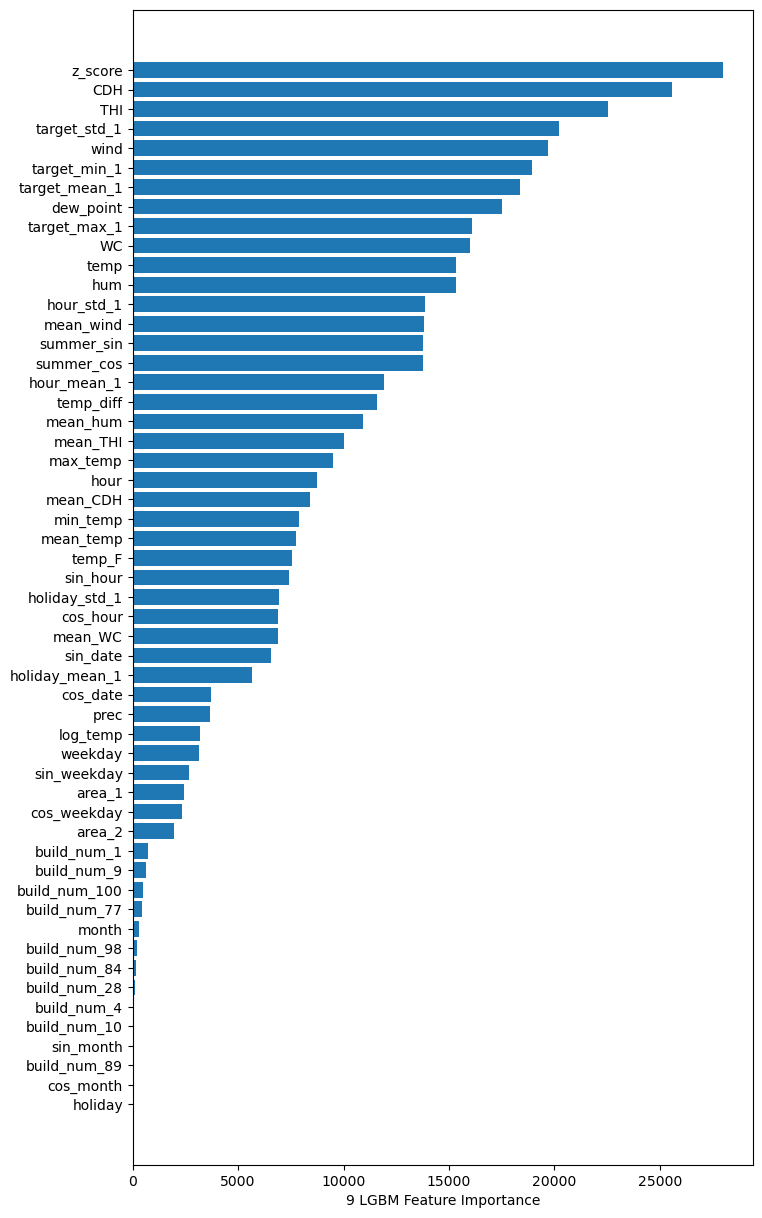

Building type = 9 : LGBM SMAPE = 4.4814
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7009
[LightGBM] [Info] Number of data points in the train set: 17485, number of used features: 54
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.313589
[1000]	valid_0's custom_smape: 0.281719
[1500]	valid_0's custom_smape: 0.267223
[2000]	valid_0's custom_smape: 0.259232
[2500]	valid_0's custom_smape: 0.253888
[3000]	valid_0's custom_smape: 0.250195
[3500]	valid_0's custom_smape: 0.247609
[4000]	valid_0's custom_smape: 0.245431
[4500]	valid_0's custom_smape: 0.243892
[5000]	valid_0's custom_smape: 0.242735
[5500]	valid_0's custom_smape: 0.241655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.240782
[6500]	valid_0's custom_smape: 0.240095
[7000]	valid_0's custom_smape: 0.239549
[7500]	valid_0's custom_smape: 0.239062
[8000]	valid_0's custom_smape: 0.238635
[8500]	valid_0's custom_smape: 0.238226
[9000]	valid_0's custom_smape: 0.237849
[9500]	valid_0's custom_smape: 0.237622
[10000]	valid_0's custom_smape: 0.237281
[10500]	valid_0's custom_smape: 0.237053
[11000]	valid_0's custom_smape: 0.23685
[11500]	valid_0's custom_smape: 0.236757
[12

[4000]	valid_0's custom_smape: 0.242687
[4500]	valid_0's custom_smape: 0.241722
[5000]	valid_0's custom_smape: 0.2408
[5500]	valid_0's custom_smape: 0.239959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.239319
[6500]	valid_0's custom_smape: 0.238774
[7000]	valid_0's custom_smape: 0.238307
[7500]	valid_0's custom_smape: 0.237941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's custom_smape: 0.237714
[8500]	valid_0's custom_smape: 0.237396
[9000]	valid_0's custom_smape: 0.23714
[9500]	valid_0's custom_smape: 0.236943
[10000]	valid_0's custom_smape: 0.236766
[10500]	valid_0's custom_smape: 0.236602
[11000]	valid_0's custom_smape: 0.236429
[11500]	valid_0's custom_smape: 0.236191
[12000]	valid_0's custom_smape: 0.236058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12500]	valid_0's custom_smape: 0.235923
[13000]	valid_0's custom_smape: 0.235801
[13500]	val

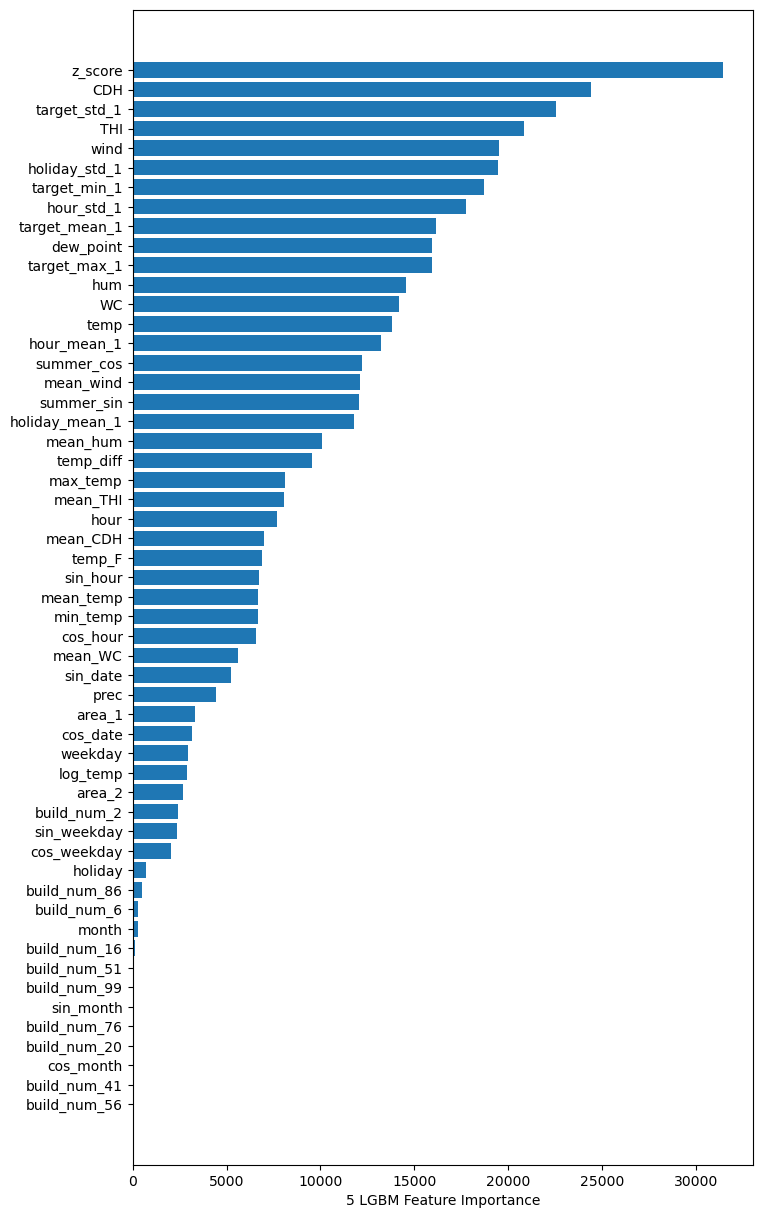

Building type = 5 : LGBM SMAPE = 1.8076
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6941
[LightGBM] [Info] Number of data points in the train set: 15737, number of used features: 53
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.323864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's custom_smape: 0.290066
[1500]	valid_0's custom_smape: 0.275243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.267163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.261684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.258602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.255967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.254269
[Light

[500]	valid_0's custom_smape: 0.333924
[1000]	valid_0's custom_smape: 0.300378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.285367
[2000]	valid_0's custom_smape: 0.276096
[2500]	valid_0's custom_smape: 0.270607
[3000]	valid_0's custom_smape: 0.266881
[3500]	valid_0's custom_smape: 0.264122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.26193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.25984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's custom_smape: 0.258565
[5500]	valid_0's custom_smape: 0.257149
[6000]	valid_0's custom_smape: 0.256072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[500]	valid_0's custom_smape: 0.320301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's custom_smape: 0.285913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.270447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.261416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.255822
[3000]	valid_0's custom_smape: 0.252515
[3500]	valid_0's custom_smape: 0.249425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.247281
[4500]	valid_0's custom_smape: 0.245714
[5000]	valid_0's custom_smape: 0.244207
[5500]	valid_0's custom_smape: 0.243043
[6000]	valid_0's custom_smape: 0.241

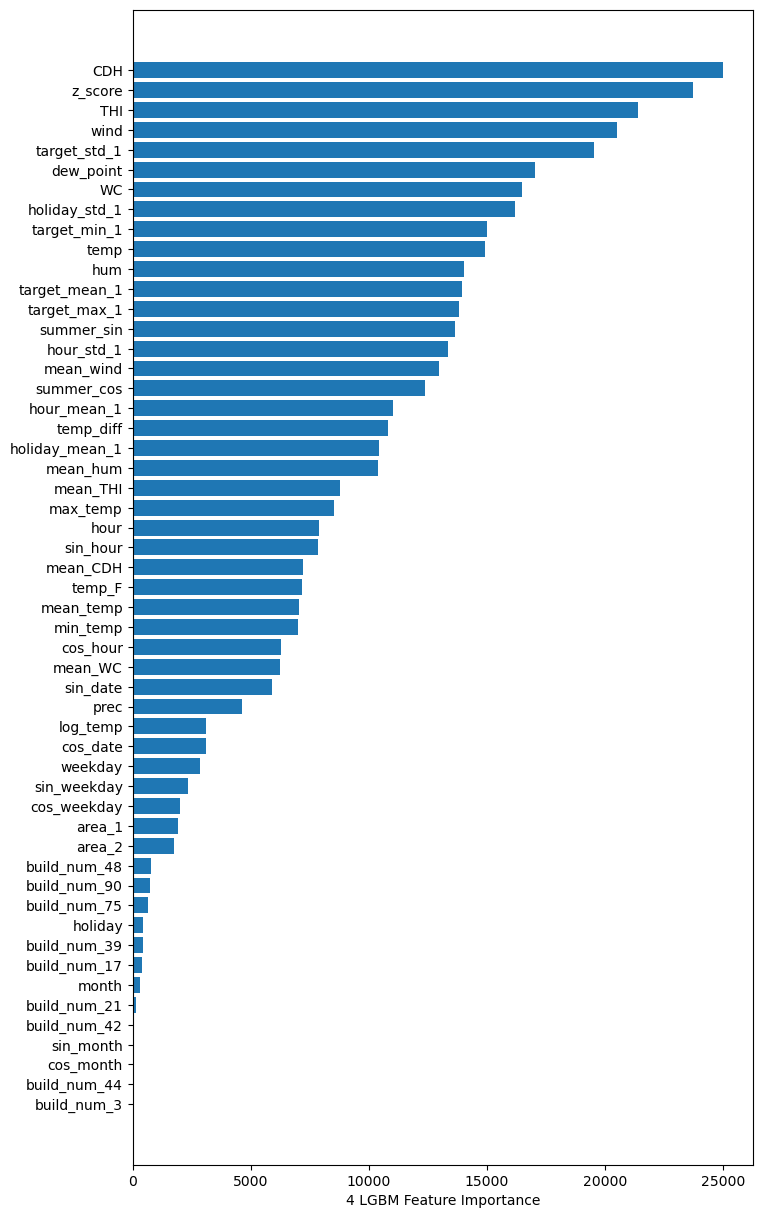

Building type = 4 : LGBM SMAPE = 1.9509
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7078
[LightGBM] [Info] Number of data points in the train set: 17485, number of used features: 54
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.406386
[1000]	valid_0's custom_smape: 0.351139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.331306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.318981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.312434
[3000]	valid_0's custom_smape: 0.30751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's custom_smape: 0.27307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8500]	valid_0's custom_smape: 0.27257
[9000]	valid_0's custom_smape: 0.272123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9500]	valid_0's custom_smape: 0.271792
[10000]	valid_0's custom_smape: 0.271406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10500]	valid_0's custom_smape: 0.271072
[11000]	valid_0's custom_smape: 0.270877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11500]	valid_0's custom_smape: 0.27063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12000]	valid_0's custom_smape: 0.270446
[12500]	valid_0's custom_smape: 0.2703

[9500]	valid_0's custom_smape: 0.273295
[10000]	valid_0's custom_smape: 0.272845
[10500]	valid_0's custom_smape: 0.272475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11000]	valid_0's custom_smape: 0.272104
[11500]	valid_0's custom_smape: 0.271775
[12000]	valid_0's custom_smape: 0.271421
[12500]	valid_0's custom_smape: 0.271126
[13000]	valid_0's custom_smape: 0.270886
[13500]	valid_0's custom_smape: 0.270705
[14000]	valid_0's custom_smape: 0.270525
[14500]	valid_0's custom_smape: 0.270292
[15000]	valid_0's custom_smape: 0.270112
Did not meet early stopping. Best iteration is:
[14990]	valid_0's custom_smape: 0.270111
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-

[1000]	valid_0's custom_smape: 0.346576
[1500]	valid_0's custom_smape: 0.327543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.316659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.310163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.305565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.302347
[4000]	valid_0's custom_smape: 0.300428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

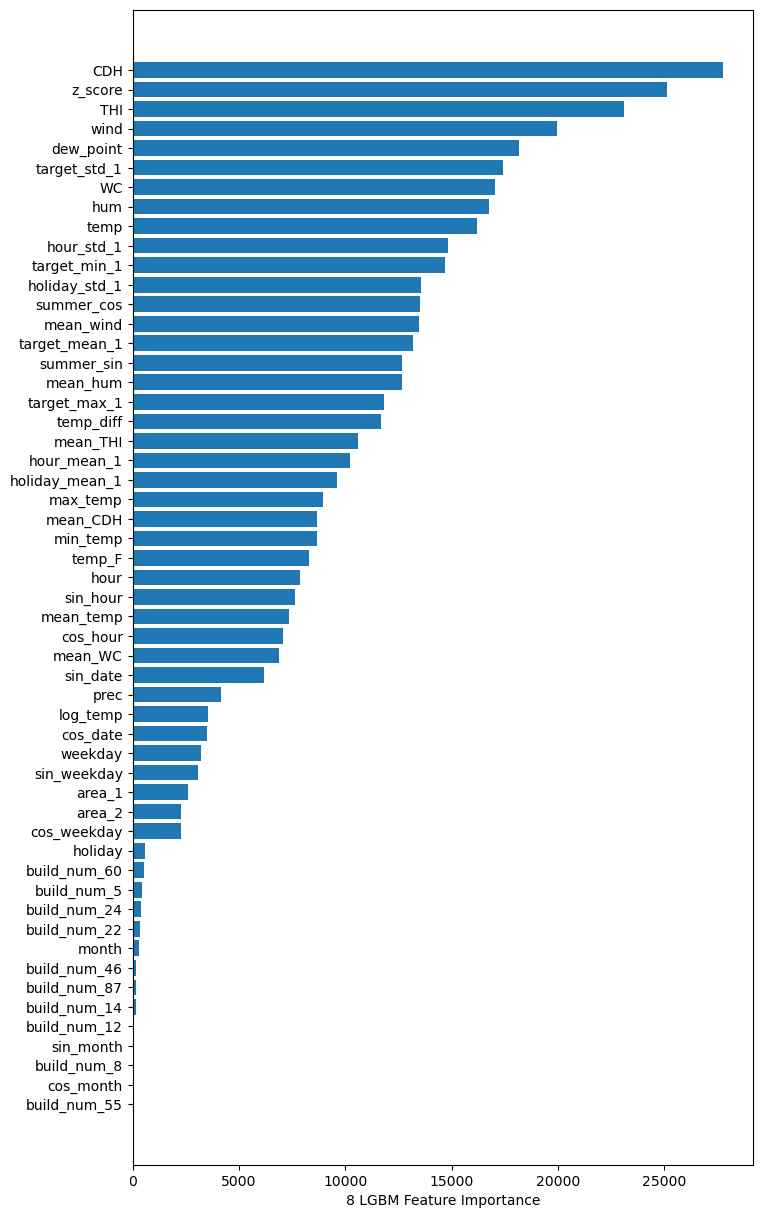

Building type = 8 : LGBM SMAPE = 2.0733
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7035
[LightGBM] [Info] Number of data points in the train set: 17485, number of used features: 54
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.569355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's custom_smape: 0.515465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.491561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[500]	valid_0's custom_smape: 0.575526
[1000]	valid_0's custom_smape: 0.522124
[1500]	valid_0's custom_smape: 0.49661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.482644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.475022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.469086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.464154
[4000]	valid_0's custom_smape: 0.461336
[4500]	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.4657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's custom_smape: 0.464643
[7000]	valid_0's custom_smape: 0.463678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7500]	valid_0's custom_smape: 0.463083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's custom_smape: 0.462726
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.465883
[4000]	valid_0's custom_smape: 0.462798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.460326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's custom_smape: 0.458858
[5500]	valid_0's custom_smape: 0.457228
[6000]	valid_0's custom_smape: 0.455971
[6500]	valid_0's custom_smape: 0.454992
[7000]	valid_0's custom_smape: 0.45411
[7500]	valid_0's custom_smape: 0.453179
[8000]	valid_0's custom_smape: 0.45274
[8500]	valid_0's custom_smape: 0.452262
Early stopping, best iteration is:
[8581]	valid_0's custom_smape: 0.452206


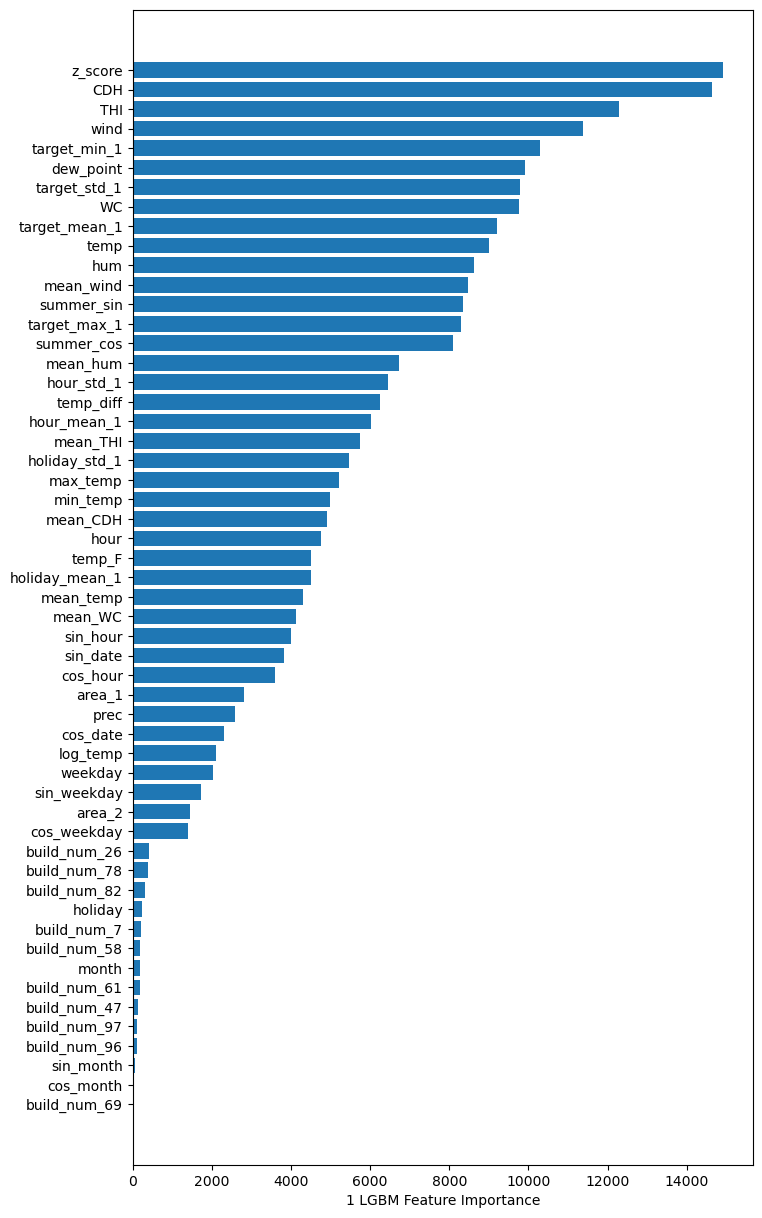

Building type = 1 : LGBM SMAPE = 3.2520
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6955
[LightGBM] [Info] Number of data points in the train set: 15737, number of used features: 52
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.722147
[1000]	valid_0's custom_smape: 0.648282
[1500]	valid_0's custom_smape: 0.614053
[2000]	valid_0's custom_smape: 0.59543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.583616
[3000]	valid_0's custom_smape: 0.57408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.567785
[4000]	valid_0's custom_smape: 0.562806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.558497
[5000]	valid_0's custom_smape: 0.555732
[5500]	valid_0's custom_smape: 0.553426
[6000]	valid_0's custom_smape: 0.551637
[6500]	valid_0's custom_smape: 0.55009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[500]	valid_0's custom_smape: 0.724201
[1000]	valid_0's custom_smape: 0.651845
[1500]	valid_0's custom_smape: 0.616932
[2000]	valid_0's custom_smape: 0.59631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.584844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.575871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.569783
[4000]	valid_0's custom_smape: 0.565607
[4500]	valid_0's custom_smape: 0.562099
[5000]	valid_0's custom_smape: 0.559669
[5500]	valid_0's custom_smape: 0.557774
[6000]	valid_0's custom_smape: 0.556063
[6500]	valid_0's custom_smape: 0.554778
[LightGBM] [Warning] No further 

[500]	valid_0's custom_smape: 0.764542
[1000]	valid_0's custom_smape: 0.681354
[1500]	valid_0's custom_smape: 0.651614
[2000]	valid_0's custom_smape: 0.632295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.621224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.614608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.609397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.604521
[4500]	valid_0's custom_smape: 0.601456
[5000]	valid_0's custom_smape: 0.599232
[5500]	valid_0's custom_smape: 0.597007
[6000]	valid_0's custom_smape: 0.59513
[6500]	valid_0's custom_smape: 0.593902
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's custom_smape: 0.578206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.576754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's custom_smape: 0.575275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7000]	valid_0's custom_smape: 0.574287
[7500]	valid_0's custom_smape: 0.573643
[8000]	valid_0's custom_smape: 0.57312
[8500]	valid_0's custom_smape: 0.572604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9000]	valid_0's custom_smape: 0.572081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9500]	valid_0's custom_smape: 0.571665
[LightGBM] [Warning] No further splits wi

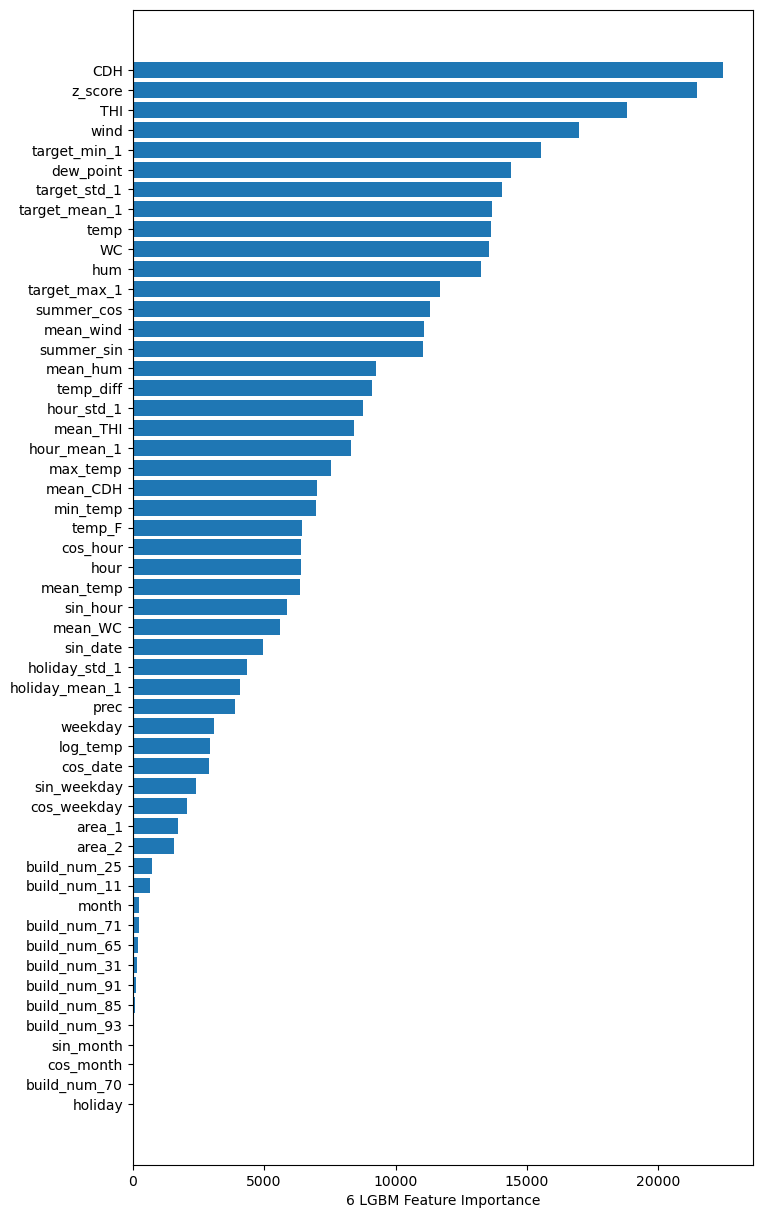

Building type = 6 : LGBM SMAPE = 2.7041
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6939
[LightGBM] [Info] Number of data points in the train set: 15737, number of used features: 53
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.527571
[1000]	valid_0's custom_smape: 0.461802
[1500]	valid_0's custom_smape: 0.437362
[2000]	valid_0's custom_smape: 0.42346
[2500]	valid_0's custom_smape: 0.413805
[3000]	valid_0's custom_smape: 0.406476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.401121
[4000]	valid_0's custom_smape: 0.397225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.394187
[5000]	valid_0's custom_smape: 0.392058
[5500]	valid_0's custom_smape: 0.389872
[6000]	valid_0's custom_smape: 0.388332
[6500]	valid_0's custom_smape: 0.387058
[7000]	valid_0's custom_smape: 0.385898
[7500]	valid_0's custom_smape: 0.385014
[8000]	valid_0's custom_smape: 0.384106
[8500]	valid_0's custom_smape: 0.383545
[9000]	valid_0's custom_smape: 0.382989
[9500]	valid_0's custom_smape: 0.382386
[10000]	valid_0's

[500]	valid_0's custom_smape: 0.538428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's custom_smape: 0.470379
[1500]	valid_0's custom_smape: 0.443827
[2000]	valid_0's custom_smape: 0.430414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.420941
[3000]	valid_0's custom_smape: 0.414709
[3500]	valid_0's custom_smape: 0.409629
[4000]	valid_0's custom_smape: 0.405558
[4500]	valid_0's custom_smape: 0.402904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's custom_smape: 0.40028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's custom_smape: 0.398385
[6000]	valid_0's custom_smape: 0.39708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's custom_smape: 0.395797
[7000]	valid_0's custom_smape: 0.394572
[7500]	valid_0's custom_smape: 0.393606
[8000]	valid_0's custom_smap

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.379314
[5000]	valid_0's custom_smape: 0.376964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's custom_smape: 0.375045
[6000]	valid_0's custom_smape: 0.37368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's custom_smape: 0.372416
[7000]	valid_0's custom_smape: 0.371268
[7500]	valid_0's custom_smape: 0.370235
[8000]	valid_0's custom_smape: 0.369526
[8500]	valid_0's custom_smape: 0.368683
[9000]	valid_0's custom_smape: 0.367946
[9500]	valid_0's custom_smape: 0.367349
[10000]	valid_0's custom_smape: 0.36681
[10500]	valid_0's custom_smape: 0.366329
[11000]	valid_0's custom_smape: 0.365871
[11500]	valid_0's custom_smape: 0.365509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12000]	valid_0's custo

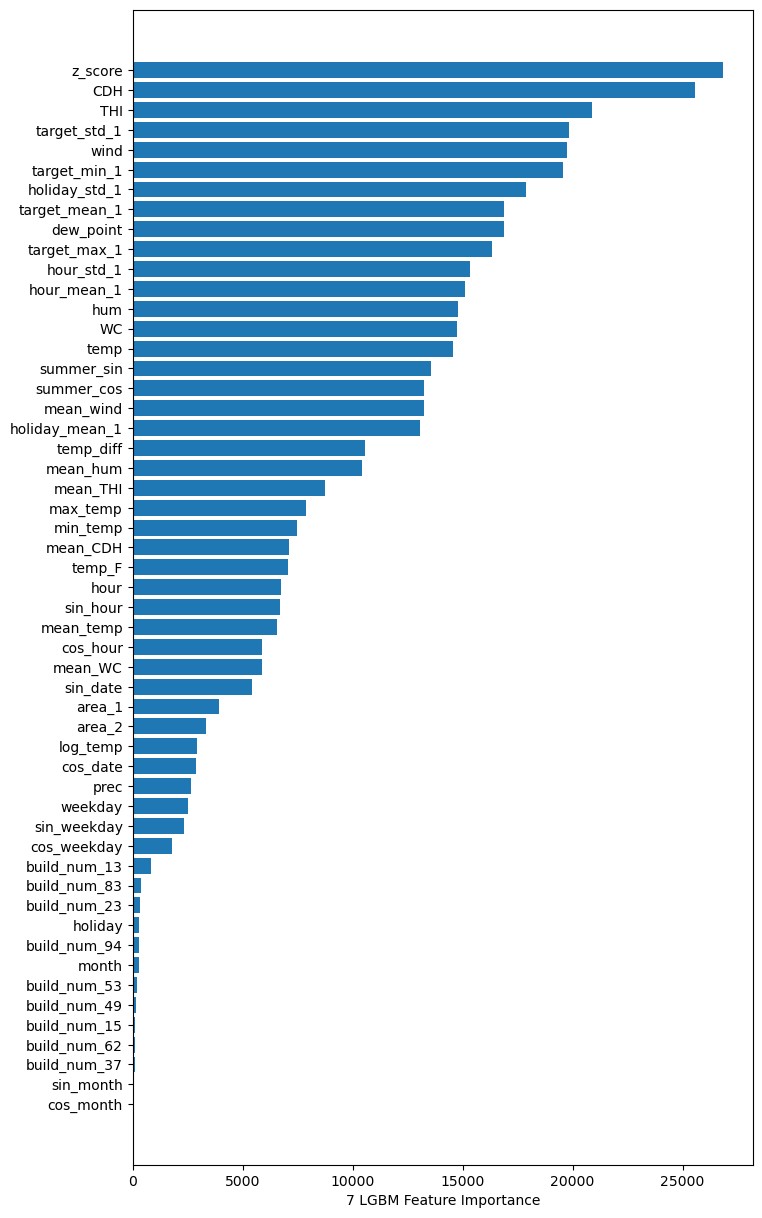

Building type = 7 : LGBM SMAPE = 2.8571
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7169
[LightGBM] [Info] Number of data points in the train set: 27977, number of used features: 60
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.651674
[1000]	valid_0's custom_smape: 0.585306
[1500]	valid_0's custom_smape: 0.553997
[2000]	valid_0's custom_smape: 0.536114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.523386
[3000]	valid_0's custom_smape: 0.513431
[3500]	valid_0's custom_smape: 0.505109
[4000]	valid_0's custom_smape: 0.499305
[4500]	valid_0's custom_smape: 0.495293
[5000]	valid_0's custom_smape: 0.491942
[5500]	valid_0's custom_smape: 0.489291
[6000]	valid_0's custom_smape: 0.486934
[6500]	valid_0's custom_smape: 0.484665
[7000]	valid_0's custom_smape: 0.482934
[7500]	valid_0's custom_smape: 0.481502
[8000]	valid_0's custom_smape: 0.480003
[8500]	valid_0's custom_smape: 0.478667
[9000]	valid_0's custom_smape: 0.47762
[9500]	valid_0's custom_smape: 0.47673
[10000]	valid_0's custom_smape: 0.475904
[10500]	valid_0's custom_smape: 0.475298
[11000]	valid_0's custom_smape: 0.474745
[11500]	valid_0's custom_smape: 0.474054
[120

[500]	valid_0's custom_smape: 0.655
[1000]	valid_0's custom_smape: 0.584728
[1500]	valid_0's custom_smape: 0.551907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.531945
[2500]	valid_0's custom_smape: 0.517867
[3000]	valid_0's custom_smape: 0.50827
[3500]	valid_0's custom_smape: 0.50127
[4000]	valid_0's custom_smape: 0.49558
[4500]	valid_0's custom_smape: 0.491216
[5000]	valid_0's custom_smape: 0.487383
[5500]	valid_0's custom_smape: 0.484811
[6000]	valid_0's custom_smape: 0.482052
[6500]	valid_0's custom_smape: 0.479504
[7000]	valid_0's custom_smape: 0.477659
[7500]	valid_0's custom_smape: 0.475827
[8000]	valid_0's custom_smape: 0.474558
[8500]	valid_0's custom_smape: 0.473116
[9000]	valid_0's custom_smape: 0.471751
[9500]	valid_0's custom_smape: 0.470714
[10000]	valid_0's custom_smape: 0.469737
[10500]	valid_0's custom_smape: 0.468949
[11000]	valid_0's custom_smape: 0.468175
[11500]	valid_0's custom_smape: 0.467403
[12000]	

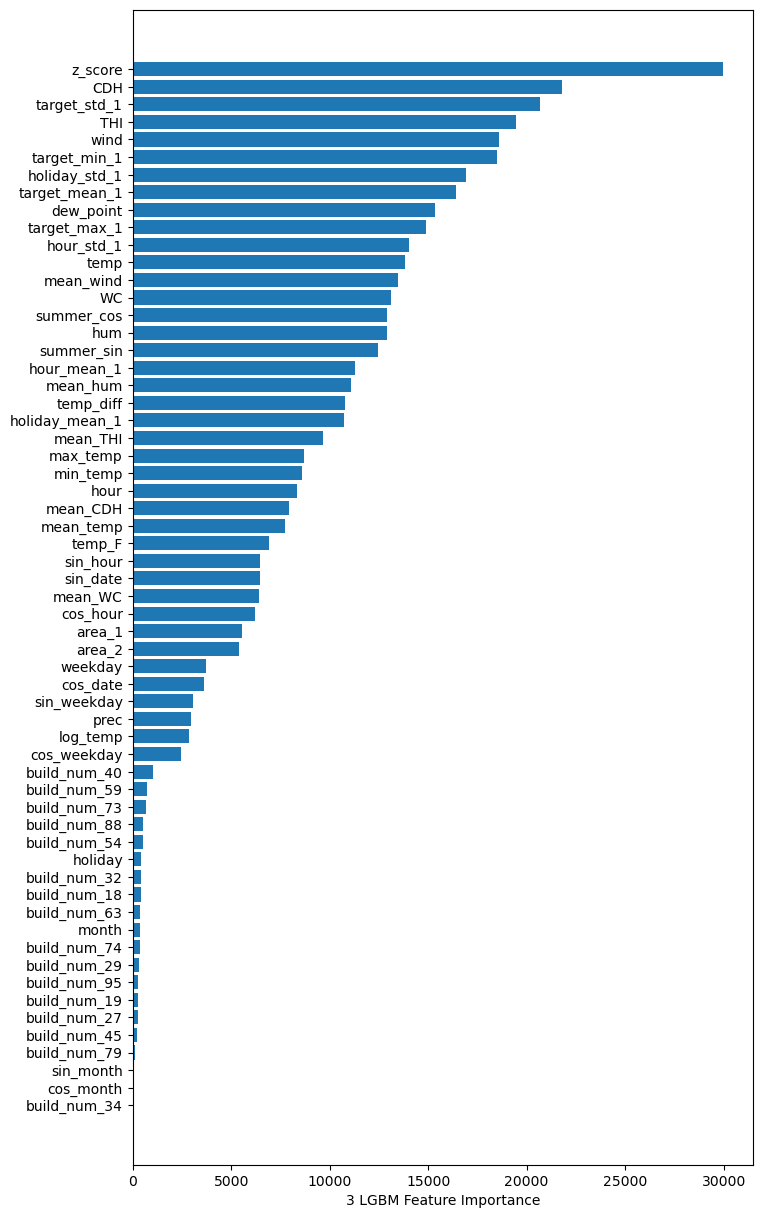

Building type = 3 : LGBM SMAPE = 3.5793
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6869
[LightGBM] [Info] Number of data points in the train set: 15593, number of used features: 53
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
Training until validation scor

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.0877755
[1000]	valid_0's custom_smape: 0.0767266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.0719182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.0694118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's custom_smape: 0.0676222
[3000]	valid_0's custom_smape: 0.0662834
[3500]	valid_0's custom_smape: 0.0653223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.0646933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.064157
[5000]	valid_0's custom_smape: 0.0637338
[5500]	valid_0's custom_smape: 0.063441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.063167
[6500]	valid_0's custom_smape: 0.063011
[LightGBM] [Warning] N

[500]	valid_0's custom_smape: 0.0849164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's custom_smape: 0.0737912
[1500]	valid_0's custom_smape: 0.0688415
[2000]	valid_0's custom_smape: 0.0661205
[2500]	valid_0's custom_smape: 0.064438
[3000]	valid_0's custom_smape: 0.0633287
[3500]	valid_0's custom_smape: 0.0626223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.0620943
[4500]	valid_0's custom_smape: 0.061688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's custom_smape: 0.0613091
[5500]	valid_0's custom_smape: 0.061032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.0608414
[6500]	valid_0's custom_smape: 0.0606231
[7000]	valid_0's custom_smape: 0.060475
[7500]	valid_0's custom_smape: 0.0603059
[LightGBM] [War

[500]	valid_0's custom_smape: 0.083445
[1000]	valid_0's custom_smape: 0.0725896
[1500]	valid_0's custom_smape: 0.0680983
[2000]	valid_0's custom_smape: 0.0657824
[2500]	valid_0's custom_smape: 0.0643578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's custom_smape: 0.0633172
[3500]	valid_0's custom_smape: 0.0627071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.0622
[4500]	valid_0's custom_smape: 0.0618257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's custom_smape: 0.0615316
[5500]	valid_0's custom_smape: 0.061291
[6000]	valid_0's custom_smape:

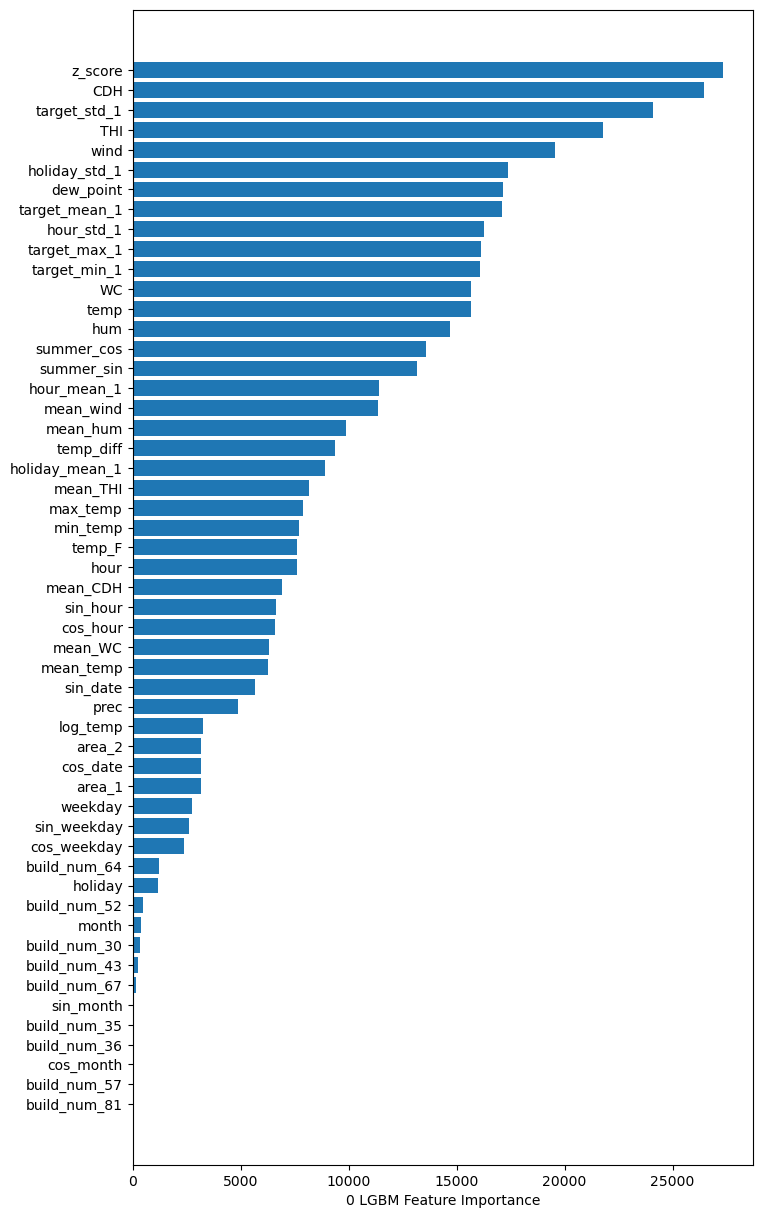

Building type = 0 : LGBM SMAPE = 0.5323
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6887
[LightGBM] [Info] Number of data points in the train set: 13988, number of used features: 52
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Usin

C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sangw\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's custom_smape: 0.623943
[1000]	valid_0's custom_smape: 0.554261
[1500]	valid_0's custom_smape: 0.525241
[2000]	valid_0's custom_smape: 0.510312
[2500]	valid_0's custom_smape: 0.499603
[3000]	valid_0's custom_smape: 0.491978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's custom_smape: 0.487423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's custom_smape: 0.483699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's custom_smape: 0.480657
[5000]	valid_0's custom_smape: 0.47825
[5500]	valid_0's custom_smape: 0.476449
[6000]	valid_0's custom_smape: 0.475298
[6500]	valid_0's custom_smape: 0.474433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7000]	valid_0's custom_smape: 0.473535
[7500]	valid_0's custom_smape: 0.472846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's custom_sma

[5500]	valid_0's custom_smape: 0.482108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's custom_smape: 0.480841
[6500]	valid_0's custom_smape: 0.479943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7000]	valid_0's custom_smape: 0.479205
[7500]	valid_0's custom_smape: 0.478568
[8000]	valid_0's custom_smape: 0.477897
[8500]	valid_0's custom_smape: 0.477384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9000]	valid_0's custom_smape: 0.476824
[9500]	valid_0's custom_smape: 0.476615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10000]	valid_0's custom_smape: 0.476337
[10500]	valid_0's custom_smape: 0.476174
Early stopping, best iteration is

[500]	valid_0's custom_smape: 0.605782
[1000]	valid_0's custom_smape: 0.537253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's custom_smape: 0.508139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's custom_smape: 0.491734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's

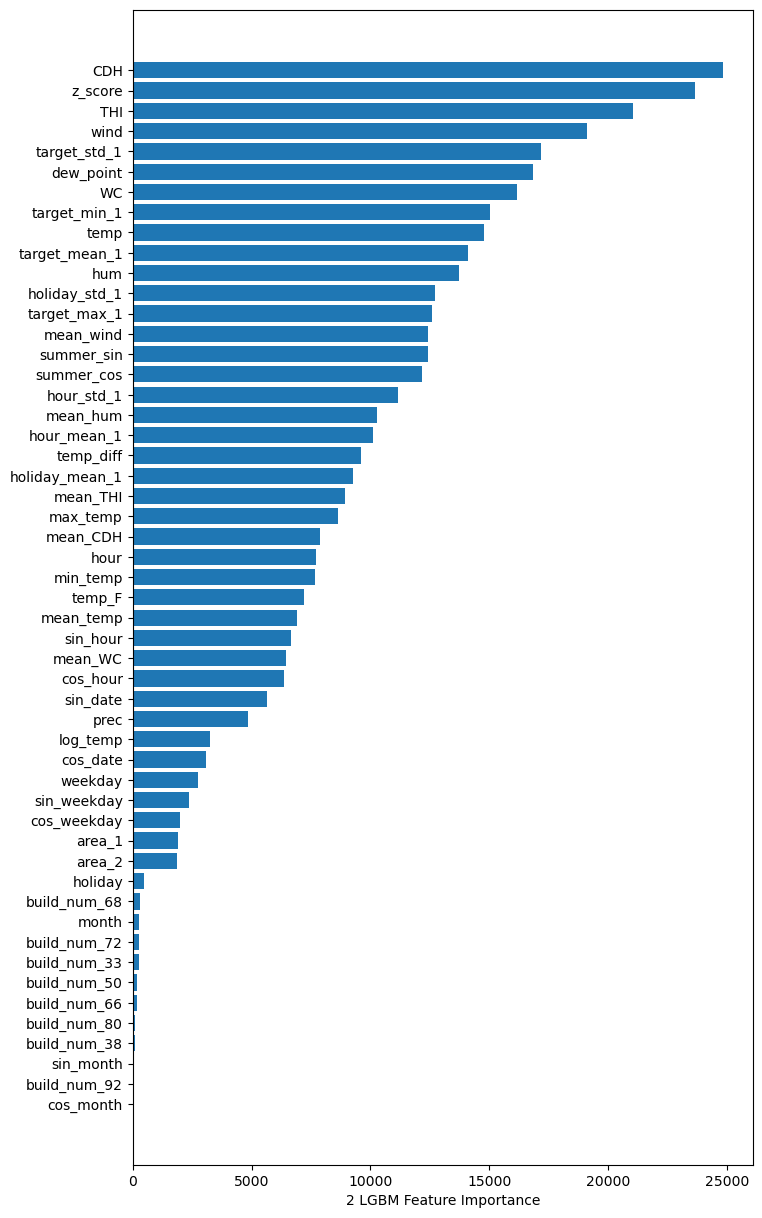

Building type = 2 : LGBM SMAPE = 3.4045


In [19]:
type_list = []
for value in train.use.values:
    if value not in type_list:
        type_list.append(value)
        
test_X = x_test
X = x_train
Y = y_train

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# 커스텀 weighted MSE
def weighted_mse_lgb(alpha=1.0):
    def custom_objective(preds, dataset):
        labels = dataset.get_label()
        residual = labels - preds
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return custom_objective

# SMAPE 평가 함수
def smape_eval_lgb(preds, dataset):
    labels = dataset.get_label()
    v = 2 * np.abs(preds - labels) / (np.abs(preds) + np.abs(labels) + 1e-6)
    return 'custom_smape', np.mean(v) * 100, False

# 전체 SMAPE 함수
def smape(gt, preds):
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt) + 1e-6)
    score = np.mean(v) * 100
    return score

import os

# 0번 GPU만 사용
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 초기 세팅
RANDOM_SEED = 42
KFOLD_SPLITS = 7

type_list = X["use"].unique()
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

for btype in type_list:
    x = X[X['use'] == btype].copy()
    y = Y[train['use'] == btype].copy()
    xt = test_X[test_X['use'] == btype].copy()

    x = pd.get_dummies(x, columns=["build_num"], drop_first=False)
    xt = pd.get_dummies(xt, columns=["build_num"], drop_first=False)
    xt = xt.reindex(columns=x.columns, fill_value=0)

    drop_cols = ["use"]
    x = x.drop(columns=drop_cols)
    xt = xt.drop(columns=drop_cols)

    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []

    x_values = x.values
    y_values = y.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        y_tr_log = np.log(y_tr + 1e-6)
        y_va_log = np.log(y_va + 1e-6)

        lgb_model = lgb.train(
            params={
                'objective': 'regression',
                'learning_rate': 0.05,
                'max_depth': 12,
                'subsample': 0.7,
                'colsample_bytree': 0.5,
                'min_child_weight': 3,
                'boosting_type': 'gbdt',
                'device': 'cpu',
                'seed': RANDOM_SEED
            },
            train_set=lgb.Dataset(X_tr, label=y_tr_log),
            valid_sets=[lgb.Dataset(X_va, label=y_va_log)],
            num_boost_round=15000,
            early_stopping_rounds=200,
            fobj=weighted_mse_lgb(5),
            feval=smape_eval_lgb,
            verbose_eval=500
        )

        va_pred = np.exp(lgb_model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred

        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)

        preds_test.append(np.exp(lgb_model.predict(xt.values)))

        if fold == KFOLD_SPLITS:
            sorted_idx = np.argsort(lgb_model.feature_importance())
            plt.figure(figsize=(8, 15))
            plt.barh(x.columns[sorted_idx], lgb_model.feature_importance()[sorted_idx])
            plt.xlabel(f"{btype} LGBM Feature Importance")
            plt.show()

    pred_df.loc[preds_valid.index, "pred"] = preds_valid
    answer_df.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)

    print(f"Building type = {btype} : LGBM SMAPE = {np.mean(fold_scores):.4f}")

In [20]:
submit = pd.read_csv("./sample_submission.csv")
submit["answer"] = answer_df.loc[submit.index, "answer"]
submit.to_csv("./submission/LGBM_info_3.csv", index=False)
print("Saved → LGBM_info_3.csv")

Saved → LGBM_info_3.csv
